In [10]:
import pandas_gbq
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [25]:
q='''
SELECT is_discount, is_voucher, is_free_delivery, is_qcommerce, is_corporate, is_commissionable, is_joker, value 
FROM `fulfillment-dwh-production.curated_data_shared_central_dwh.orders` 
where is_sent = true and global_entity_id="FO_NO" and date(placed_at_local) = "2023-12-12"
'''

In [26]:
df = pandas_gbq.read_gbq(q)

Downloading: 100%|██████████|


In [27]:
df.columns

Index(['is_discount', 'is_voucher', 'is_free_delivery', 'is_qcommerce',
       'is_corporate', 'is_commissionable', 'is_joker', 'value'],
      dtype='object')

In [55]:
df['value'][0]

{'commission_base_local': Decimal('372.300000000'),
 'commission_base_eur': Decimal('31.450000000'),
 'commission_local': Decimal('105.120000000'),
 'commission_eur': Decimal('8.880000000'),
 'voucher_dh_local': None,
 'voucher_dh_eur': None,
 'voucher_other_local': None,
 'voucher_other_eur': None,
 'discount_dh_local': Decimal('65.700000000'),
 'discount_dh_eur': Decimal('5.550000000'),
 'discount_other_local': Decimal('65.700000000'),
 'discount_other_eur': Decimal('5.550000000'),
 'joker_customer_discount_local': Decimal('0E-9'),
 'joker_customer_discount_eur': Decimal('0E-9'),
 'delivery_fee_local': Decimal('19.000000000'),
 'delivery_fee_eur': Decimal('1.610000000'),
 'delivery_fee_vat_local': Decimal('2.480000000'),
 'delivery_fee_vat_eur': Decimal('0.210000000'),
 'customer_paid_local': Decimal('334.600000000'),
 'customer_paid_eur': Decimal('28.270000000'),
 'joker_vendor_fee_local': Decimal('0E-9'),
 'joker_vendor_fee_eur': Decimal('0E-9'),
 'gmv_local': Decimal('334.60000000

In [36]:
df['commission_base_eur'] = df['value'].apply(lambda x: x.get('commission_base_eur', 0))
df['commission_eur'] = df['value'].apply(lambda x: x.get('commission_eur', 0))
df['voucher_dh_eur'] = df['value'].apply(lambda x: x.get('voucher_dh_eur', 0))
df['voucher_other_eur'] = df['value'].apply(lambda x: x.get('voucher_other_eur', 0))
df['discount_dh_eur'] = df['value'].apply(lambda x: x.get('discount_dh_eur', 0))
df['joker_customer_discount_eur'] = df['value'].apply(lambda x: x.get('joker_customer_discount_eur', 0))
df['joker_vendor_fee_eur'] = df['value'].apply(lambda x: x.get('joker_vendor_fee_eur', 0))

print("commission_base_eur", df['commission_base_eur'].max())
print("commission_eur", df['commission_eur'].max())
print("voucher_dh_eur", df['voucher_dh_eur'].max())
print("voucher_other_eur", df['voucher_other_eur'].max())
print("discount_dh_eur", df['discount_dh_eur'].max())
print("joker_customer_discount_eur", df['joker_customer_discount_eur'].max())
print("joker_vendor_fee_eur", df['joker_vendor_fee_eur'].max())

commission_base_eur 403.850000000
commission_eur 100.960000000
voucher_dh_eur 64.380000000
voucher_other_eur 0E-9
discount_dh_eur 29.350000000
joker_customer_discount_eur 8.480000000
joker_vendor_fee_eur 89.240000000


**GMV=service fee+gbv+delivery fee-discounts**

In [63]:
i=163 #incorrect for i=0

In [64]:
df['value'][i]['gmv_eur'], \
df['value'][i]['service_fee_eur']+df['value'][i]['gbv_eur']+df['value'][i]['delivery_fee_eur']-df['value'][i]["discount_other_eur"]-df["value"][i]["discount_dh_eur"]

(Decimal('20.190000000'), Decimal('20.190000000'))

In [67]:
df['incentive_value'] = df['value'].apply(lambda x: x.get('discount_dh_eur', 0) + x.get('discount_other_eur', 0) \
                                          + (0 if x.get('voucher_dh_eur') is None else x.get('voucher_dh_eur')) \
                                          + (0 if x.get('voucher_other_eur') is None else x.get('voucher_other_eur')))

df['basket_value'] = df['value'].apply(lambda x: x.get('service_fee_eur', 0) + x.get('gbv_eur', 0) + x.get('delivery_fee_eur', 0) + x.get('joker_customer_discount_eur', 0) )

In [68]:
def plot_hist(df, subset):
    df_sub = df[df[subset]==True]
    print("Share: %", round(len(df_sub)*100/len(df), 2))
    fig, ax = plt.subplots(figsize = (4,4))
    ax.hist(df_sub['incentive_value'], alpha=0.5, label='incentive_value')
    ax.hist(df_sub['basket_value'], alpha=0.5, label='basket_value')
    ax.legend(loc='upper right')
    plt.show()

def plot_all(df):
    for col in df.columns:
        if "value" not in col and "is_" in col:
            print(col)
            plot_hist(df, col)

is_discount
Share: % 22.97


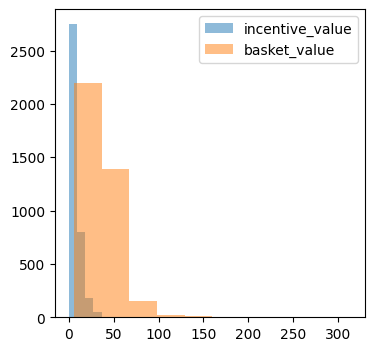

is_voucher
Share: % 10.5


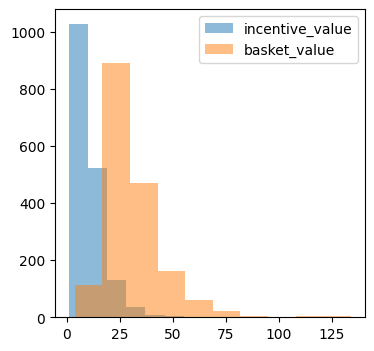

is_free_delivery
Share: % 28.78


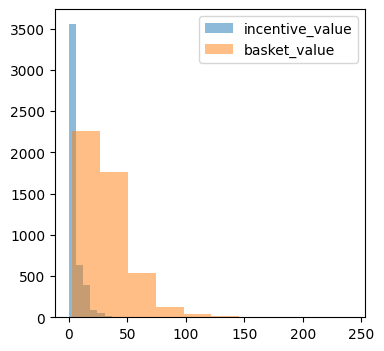

is_qcommerce
Share: % 9.48


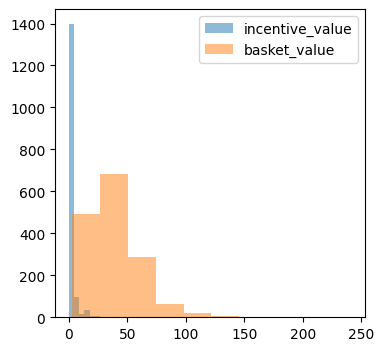

is_corporate
Share: % 1.27


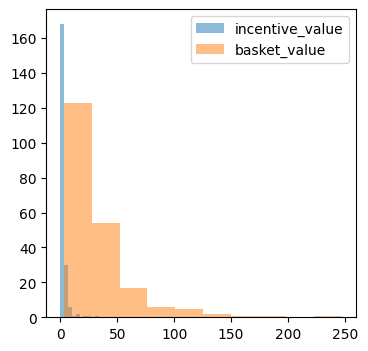

is_commissionable
Share: % 100.0


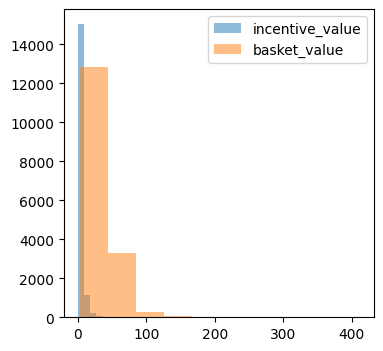

is_joker
Share: % 3.4


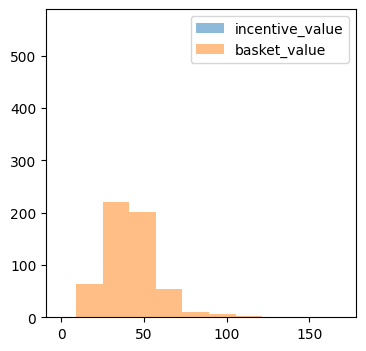

In [69]:
plot_all(df) #EUR

In [49]:
df.columns

Index(['is_discount', 'is_voucher', 'is_free_delivery', 'is_qcommerce',
       'is_corporate', 'is_commissionable', 'is_joker', 'value',
       'commission_base_eur', 'commission_eur', 'voucher_dh_eur',
       'voucher_other_eur', 'discount_dh_eur', 'joker_customer_discount_eur',
       'joker_vendor_fee_eur', 'incentive_value', 'basket_value'],
      dtype='object')

### Columns description:
#### Incentives
- **is_discount**: True if some other discount was given to the customer (other than voucher and joker), e.g. Meal deal / Happy hour / Free drink / Pizza Montag / Free Delivery etc.	
- **is_voucher**: True if a voucher code was used, when the customer types in a code during the order process to receive a price reduction.	
- **is_free_delivery**: True if there was no delivery fee for the order.	
- **is_qcommerce**: True if order was not a food restaurant order.	
- **is_corporate**: True if order is paid between real customer and the company supporting it. For example, DH corporate orders are supported by DH with 6 € per order. It should be true when there is a separate app for other companies to give their employees some kind of benefit.	
- **is_commissionable**: True if the order should be taken into account for billing, e.g. if commission can be charged to the restaurant for this order.	
- **is_joker**: True if the joker feature was used in the order process.


Commission data infor comes a month later, however January did not seem to have data for the day